#### 01_PySpark Data_Ingest and ETL: Hospital Readmission Prediction for Diabetic Patients

##### 1. Environment Setup and Spark Initialization

In [ ]:
# Import necessary libraries and functions 
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, IntegerType, FloatType

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

print("All packages imported successfully!")

In [ ]:
# Initialize Spark Session with optimized settings
import os
from pyspark.sql import SparkSession

# Set environment variables (if not set in terminal)
os.environ["HADOOP_HOME"] = "C:\\hadoop"
os.environ["JAVA_HOME"] = "C:\\Program Files\\Java\\jdk-20"

spark = SparkSession.builder \
    .appName("DiabeticReadmission") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "2g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.hadoop.security.authentication", "simple") \
    .config("spark.hadoop.security.authorization", "false") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .getOrCreate()

print(f"✓ Spark session initialized successfully!")
print(f"Spark version: {spark.version}")
print(f"Available cores: {spark.sparkContext.defaultParallelism}")

##### 2. Data Ingestion

<small>
The dataset is originally obtained from Diabetes 130-US Hospitals. The aim is to predict the readmission risk for diabetic patient within 30 days of discharge.

In [8]:
# Load the dataset
df = spark.read.csv('C:\Projects\hospital_readmission_prediction\data\diabetes_130_us_hospitals\diabetic_data.csv', header=True, inferSchema=True)

In [9]:
# Intial insection of data
df.show(5)

+------------+-----------+---------------+------+-------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|           race|gender|    age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnos

In [10]:
# Check the dimensions of the data
print(f"Rows: {df.count()}, Columns: {len(df.columns)}")

Rows: 101766, Columns: 50


##### 3. Intial data exploration and preprocessing

In [ ]:
# Preview schema of the dataframe
df.printSchema()

In [ ]:
# Separate categorical and numerical columns

categorical_cols = [field for (field, dtype) in df.dtypes if dtype == "string"]
numerical_cols = [field for (field, dtype) in df.dtypes if dtype in ("int", "double", "float", "bigint")]

print(f"Total categorical columns: {len(categorical_cols)}")
print(f"Total numerical columns:{len(numerical_cols)}")

print(f"Categorical Features: {', '.join(categorical_cols)}")
print(f"Numerical Features: {', '.join(numerical_cols)}")

Total categorical columns: 37
Total numerical columns:13
Categorical Features: race, gender, age, weight, payer_code, medical_specialty, diag_1, diag_2, diag_3, max_glu_serum, A1Cresult, metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, citoglipton, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, metformin-pioglitazone, change, diabetesMed, readmitted
Numerical Features: encounter_id, patient_nbr, admission_type_id, discharge_disposition_id, admission_source_id, time_in_hospital, num_lab_procedures, num_procedures, num_medications, number_outpatient, number_emergency, number_inpatient, number_diagnoses


In [ ]:
# Check for missing values
"""
Count null values in each column
"""
from pyspark.sql.functions import col, sum

df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+------------+-----------+----+------+---+------+-----------------+------------------------+-------------------+----------------+----------+-----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|race|gender|age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin

In [ ]:
# Analyze specific string such as (?) in the dataset
# Dictionary to store the counts of '?'
special_char_counts = {}

# Iterate over all columns in the DataFrame
for col_name in df.columns:
    if dict(df.dtypes)[col_name] == 'string':
        count_missing = df.filter(F.col(col_name) == '?').count()
        special_char_counts[col_name] = count_missing
for col_name, count in special_char_counts.items():
    print(f"{col_name}: {count}")

race: 2273
gender: 0
age: 0
weight: 98569
payer_code: 40256
medical_specialty: 49949
diag_1: 21
diag_2: 358
diag_3: 1423
max_glu_serum: 0
A1Cresult: 0
metformin: 0
repaglinide: 0
nateglinide: 0
chlorpropamide: 0
glimepiride: 0
acetohexamide: 0
glipizide: 0
glyburide: 0
tolbutamide: 0
pioglitazone: 0
rosiglitazone: 0
acarbose: 0
miglitol: 0
troglitazone: 0
tolazamide: 0
examide: 0
citoglipton: 0
insulin: 0
glyburide-metformin: 0
glipizide-metformin: 0
glimepiride-pioglitazone: 0
metformin-rosiglitazone: 0
metformin-pioglitazone: 0
change: 0
diabetesMed: 0
readmitted: 0


In [ ]:
# Percentage of special character (?)

total_rows = df.count()
special_char ={}
dtype_dict = dict(df.dtypes)

for col_name in df.columns:
    if dtype_dict[col_name] == 'string':
        count_missing = df.filter(F.col(col_name) == '?').count()
        if count_missing > 0:
            percent_missing = (count_missing / total_rows) * 100
            special_char[col_name] = percent_missing
for col_name, percent in special_char.items():
    print(f"{col_name}: {percent:.2f}%")


race: 2.23%
weight: 96.86%
payer_code: 39.56%
medical_specialty: 49.08%
diag_1: 0.02%
diag_2: 0.35%
diag_3: 1.40%


In [ ]:
# Drop columns with high percentage of missing values (?)
df = df.drop('weight', 'payer_code', 'medical_specialty')
df.describe().show()

+-------+--------------------+--------------------+------+---------------+--------+-----------------+------------------------+-------------------+-----------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|summary|        encounter_id|         patient_nbr|  race|         gender|     age|admission_type_id|discharge_disposition_id|admission_source_id| time_in_hospital|num_lab_procedures|    num_procedures|   num_medications|  number_outpatient|   number_emergency|  number_inp

In [ ]:
print(f"Rows: {df.count()}, Columns: {len(df.columns)}")

Rows: 101766, Columns: 47


In [ ]:
# Analyze each features 
"""1.Encounter_id"""
unique_count = df.select('encounter_id').distinct().count()
print(unique_count)

101766


In [ ]:
"""2.patient_nbr"""
unique_count = df.select('patient_nbr').distinct().count()
print(unique_count)

71518


<small>
Both encounter_id and patient_nbr are identifiers the value tells nothing to readmission risk of another, dropout them

In [ ]:
df = df.drop('encounter_id', 'patient_nbr')

In [ ]:
"""3.race"""
df.groupBy('race').count().orderBy(F.desc("count")).show()

+---------------+-----+
|           race|count|
+---------------+-----+
|      Caucasian|76099|
|AfricanAmerican|19210|
|              ?| 2273|
|       Hispanic| 2037|
|          Other| 1506|
|          Asian|  641|
+---------------+-----+



In [ ]:
"""First, impute missing values (?) with na.replace"""

df = df.na.replace(["?"], [None], subset=["race"])
df.select("race").distinct().show()

+---------------+
|           race|
+---------------+
|      Caucasian|
|          Other|
|AfricanAmerican|
|       Hispanic|
|          Asian|
|           NULL|
+---------------+



In [ ]:
"""Then, impute the race column with the mode (most frequent value)"""
mode_race_row = df.groupBy("race") \
    .count() \
    .orderBy(F.desc("count")) \
    .first()

if mode_race_row is not None:
    mode_race = mode_race_row["race"]
    print(f"Mode race: {mode_race}")
    df = df.fillna({"race": mode_race})
else:
    print("No mode found for race column.")

df = df.fillna({"race": mode_race})

Mode race: Caucasian


In [ ]:
'''verify if race feature column is imputed with the mode'''

df.groupBy('race').count().orderBy(F.desc("count")).show()

+---------------+-----+
|           race|count|
+---------------+-----+
|      Caucasian|78372|
|AfricanAmerican|19210|
|       Hispanic| 2037|
|          Other| 1506|
|          Asian|  641|
+---------------+-----+



In [ ]:
"""4.gender"""
df.groupBy('gender').count().orderBy(F.desc("count")).show()

+---------------+-----+
|         gender|count|
+---------------+-----+
|         Female|54708|
|           Male|47055|
|Unknown/Invalid|    3|
+---------------+-----+



In [ ]:
'''#impute invalid/unknown gender values'''

df = df.na.replace(["Unknown/Invalid", "?"], None, subset=["gender"])

mode_row_obj = (
    df.filter(F.col("gender").isNotNull())
      .groupBy("gender")
      .count()
      .orderBy(F.desc("count"))
      .first()
)

if mode_row_obj is not None:
    mode_row = mode_row_obj[0]
    print(f"Mode value for gender: {mode_row}")
    df = df.na.fill(mode_row, subset=["gender"])
else:
    print("No mode found for gender column.")

Mode value for gender: Female


In [ ]:
df.groupBy('gender').count().orderBy(F.desc("count")).show()

+------+-----+
|gender|count|
+------+-----+
|Female|54711|
|  Male|47055|
+------+-----+



In [ ]:
'''check the imputed columns for special string and invalid values in df'''

df = df.na.replace(['?'], [None])

missing_counts = [
    (col, df.filter(F.col(col).isNull()).count())
    for col in df.columns]

for col, count in missing_counts:
    print(f"{col}: {count}")

race: 0
gender: 0
age: 0
admission_type_id: 0
discharge_disposition_id: 0
admission_source_id: 0
time_in_hospital: 0
num_lab_procedures: 0
num_procedures: 0
num_medications: 0
number_outpatient: 0
number_emergency: 0
number_inpatient: 0
diag_1: 21
diag_2: 358
diag_3: 1423
number_diagnoses: 0
max_glu_serum: 0
A1Cresult: 0
metformin: 0
repaglinide: 0
nateglinide: 0
chlorpropamide: 0
glimepiride: 0
acetohexamide: 0
glipizide: 0
glyburide: 0
tolbutamide: 0
pioglitazone: 0
rosiglitazone: 0
acarbose: 0
miglitol: 0
troglitazone: 0
tolazamide: 0
examide: 0
citoglipton: 0
insulin: 0
glyburide-metformin: 0
glipizide-metformin: 0
glimepiride-pioglitazone: 0
metformin-rosiglitazone: 0
metformin-pioglitazone: 0
change: 0
diabetesMed: 0
readmitted: 0


In [ ]:
'''5.Age'''

df.groupBy('age').count().orderBy(F.desc("count")).show()

+--------+-----+
|     age|count|
+--------+-----+
| [70-80)|26068|
| [60-70)|22483|
| [50-60)|17256|
| [80-90)|17197|
| [40-50)| 9685|
| [30-40)| 3775|
|[90-100)| 2793|
| [20-30)| 1657|
| [10-20)|  691|
|  [0-10)|  161|
+--------+-----+



</small>

_Transform the binned categorical age feature into a single numeric value(midpoint)
and the majority of age groups are 50-80_

In [ ]:
#assign numeric midpoints to age groups
df = df.withColumn("age",
       F.when(F.col("age") == "[0-10)", 5)
        .when(F.col("age") == "[10-20)", 15)
        .when(F.col("age") == "[20-30)", 25)
        .when(F.col("age") == "[30-40)", 35)
        .when(F.col("age") == "[40-50)", 45)
        .when(F.col("age") == "[50-60)", 55)
        .when(F.col("age") == "[60-70)", 65)
        .when(F.col("age") == "[70-80)", 75)
        .when(F.col("age") == "[80-90)", 85)
        .when(F.col("age") == "[90-100)", 95)
        .otherwise(None)
)
df = df.withColumn("age", F.col("age").cast(IntegerType()))

In [ ]:
df.groupBy('age').count().orderBy(F.desc('count')).show()

+---+-----+
|age|count|
+---+-----+
| 75|26068|
| 65|22483|
| 55|17256|
| 85|17197|
| 45| 9685|
| 35| 3775|
| 95| 2793|
| 25| 1657|
| 15|  691|
|  5|  161|
+---+-----+



In [ ]:
'''6.admission_type_id'''

df.groupBy('admission_type_id').count().orderBy(F.desc('count')).show()

+-----------------+-----+
|admission_type_id|count|
+-----------------+-----+
|                1|53990|
|                3|18869|
|                2|18480|
|                6| 5291|
|                5| 4785|
|                8|  320|
|                7|   21|
|                4|   10|
+-----------------+-----+



</small>

*Mapping admission_type_id to description of type of id from IDS_mapping.csv*

In [ ]:
# Importing IDS_mapping file
admission_type_mapping = spark.read.csv('C:\Projects\hospital_readmission_prediction\data\diabetes_130_us_hospitals\IDS_mapping.csv', header=True, inferSchema=True)
admission_type_mapping.select("admission_type_id", "description").show(8)

+-----------------+-------------+
|admission_type_id|  description|
+-----------------+-------------+
|                1|    Emergency|
|                2|       Urgent|
|                3|     Elective|
|                4|      Newborn|
|                5|Not Available|
|                6|         NULL|
|                7|Trauma Center|
|                8|   Not Mapped|
+-----------------+-------------+
only showing top 8 rows


<small>  

Feature mapping of admission_type_id to description:   
 Perfomed after feature consolidations i.e similar description is reorganized  
 1-Emergency: includes Emergency(1), Urget(2), Trauma Center(7)  
 2-Elective: includes only Elective(3)  
 3-Newborn: include only Newborn (4)  
 4-Not Available: includes Not Available(5), NULL(6), Not Mapped(8)  


In [ ]:
df = df.withColumn(
    "admission_type_id",
    F.when(F.col("admission_type_id").isin(1, 2, 7), "Emergency")
     .when(F.col("admission_type_id").isin(5, 6, 8), "Not Available")
     .when(F.col("admission_type_id") == 3, "Elective")
     .when(F.col("admission_type_id") == 4, "Newborn")
     .otherwise("Other")
     .cast(StringType())
)

In [ ]:
df.groupBy("admission_type_id").count().orderBy(F.desc("count")).show()

+-----------------+-----+
|admission_type_id|count|
+-----------------+-----+
|        Emergency|72491|
|         Elective|18869|
|    Not Available|10396|
|          Newborn|   10|
+-----------------+-----+



In [ ]:
newborn_df = df.where(df['admission_type_id'] == 'Newborn')
newborn_df.show(5)

+---------------+------+---+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|           race|gender|age|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|nateglinide|chlorpropamide|glimepiride|acetohexamide|glipizide|glyburide|tolbutamide|pi

<small>

*The Newborn admission type does not align with age features and have diffrent          characterstics than adults,  and drop it*

In [ ]:
from pyspark.sql.functions import col

values_to_remove = ['Newborn']
df = df.filter(~col('admission_type_id').isin(values_to_remove))

In [ ]:
df.groupBy("admission_type_id").count().orderBy(F.desc("count")).show()

+-----------------+-----+
|admission_type_id|count|
+-----------------+-----+
|        Emergency|72491|
|         Elective|18869|
|    Not Available|10396|
+-----------------+-----+



In [ ]:
'''7. discharge_disposition_id'''

df.groupBy("discharge_disposition_id").count().orderBy(F.desc("count")).show()

+------------------------+-----+
|discharge_disposition_id|count|
+------------------------+-----+
|                       1|60228|
|                       3|13954|
|                       6|12898|
|                      18| 3691|
|                       2| 2128|
|                      22| 1993|
|                      11| 1642|
|                       5| 1184|
|                      25|  989|
|                       4|  815|
|                       7|  623|
|                      23|  412|
|                      13|  399|
|                      14|  372|
|                      28|  139|
|                       8|  108|
|                      15|   63|
|                      24|   48|
|                       9|   21|
|                      17|   14|
+------------------------+-----+
only showing top 20 rows


In [ ]:
#Check Unique values in the column
df.select("discharge_disposition_id").distinct().show()

+------------------------+
|discharge_disposition_id|
+------------------------+
|                      12|
|                      22|
|                       1|
|                      13|
|                       6|
|                      16|
|                       3|
|                       5|
|                      17|
|                       9|
|                       4|
|                       8|
|                      23|
|                       7|
|                      10|
|                      25|
|                      11|
|                      14|
|                       2|
|                      18|
+------------------------+
only showing top 20 rows


<small>

*Extracting and cleaning discharge_disposition_id section from IDS_mapping file. Since the file contain multiple mapping so needs to isolate specific file using sorrogate column to preserve column order*

In [ ]:
from pyspark.sql.functions import col, row_number
from pyspark.sql.window import Window

# Read all rows as data (no header)
csv_path = r"C:\Projects\hospital_readmission_prediction\data\diabetes_130_us_hospitals\IDS_mapping.csv"
raw_mapping = spark.read.csv(csv_path, header=False, inferSchema=True).toDF("id_or_label", "description")

# Add a sequential index using a Window function (based on file order)
window_spec = Window.orderBy("id_or_label")

# Add a row index to preserve file order
from pyspark.sql.functions import monotonically_increasing_id
raw_mapping = raw_mapping.withColumn("order_id", monotonically_increasing_id())
window_spec = Window.orderBy("order_id")
mapped_with_index = raw_mapping.withColumn("row_idx", row_number().over(window_spec))

# Find section boundary
start_label = "discharge_disposition_id"
end_label = "admission_source_id" 

#Extract only discharge_disposition_id section
discharge_start_idx = mapped_with_index.filter(col("id_or_label") == start_label).select("row_idx").collect()[0][0]
discharge_end_idx = mapped_with_index.filter(col("id_or_label") == end_label).select("row_idx").collect()[0][0]

# Filter the dataframe using indices
discharge_mapping = mapped_with_index.filter(
    (col("row_idx") > discharge_start_idx) & (col("row_idx") < discharge_end_idx)
).drop("row_idx", "order_id")

# Rename columns 
discharge_mapping = discharge_mapping.toDF("discharge_disposition_id", "description")

# Keep only numeric IDs in the first column
discharge_mapping = discharge_mapping.filter(col("discharge_disposition_id").rlike("^[0-9]+$"))

discharge_mapping.show(30, truncate=False)

+------------------------+---------------------------------------------------------------------------------------------------------+
|discharge_disposition_id|description                                                                                              |
+------------------------+---------------------------------------------------------------------------------------------------------+
|1                       |Discharged to home                                                                                       |
|2                       |Discharged/transferred to another short term hospital                                                    |
|3                       |Discharged/transferred to SNF                                                                            |
|4                       |Discharged/transferred to ICF                                                                            |
|5                       |Discharged/transferred to another type of i

*Feature mapping of discharge_disposition_id to description*

<small>

Similar descriptions are categorized as follows:       
1- Discharge to home                          => 1,6,8    
2- Transfered to another facility             => 2,3,4,5,16,22,23,24,27,28,29,30  
3- AMA                                        => 7  
4- Still patient/refrred to this institution  => 9,12,15,17   
5- Neonate discharge                          => 10   
6- Expired                                    => 11,19,20,21  
7- Hospice                                    => 13,14   
8- Not Available                              => 18,25,26    

In [ ]:
# Define the logic clearly as shown above
df = df.withColumn(
    "discharge_disposition_id", # Create a new column with the description
    F.when(F.col("discharge_disposition_id").isin([1, 6, 8]), "Discharged to home")
     .when(F.col("discharge_disposition_id").isin([2, 3, 4, 5, 16, 22, 23, 24, 27, 28, 29, 30]), "Transferred to another facility")
     .when(F.col("discharge_disposition_id") == 7, "Left AMA")
     .when(F.col("discharge_disposition_id").isin([9, 12, 15, 17]), "Still patient/referred to this institution")
     .when(F.col("discharge_disposition_id") == 10, "Neonate discharged")
     .when(F.col("discharge_disposition_id").isin([11, 19, 20, 21]), "Expired")
     .when(F.col("discharge_disposition_id").isin([13, 14]), "Hospice")
     .when(F.col("discharge_disposition_id").isin([18, 25, 26]), "Not Available")
     .otherwise("Other/Unknown") # Always good practice to have a fallback
     .cast(StringType())
)

In [ ]:
df.groupBy("discharge_disposition_id").count().orderBy(F.desc("count")).show()

+------------------------+-----+
|discharge_disposition_id|count|
+------------------------+-----+
|      Discharged to home|73234|
|    Transferred to an...|20689|
|           Not Available| 4680|
|                 Expired| 1652|
|                 Hospice|  771|
|                Left AMA|  623|
|    Still patient/ref...|  101|
|      Neonate discharged|    6|
+------------------------+-----+



<small>

*Among discharge_disposition_id description: Neonate(newborns) and Expired _irrelavnt to predictive task so should be removed from the column*

In [ ]:
value_to_remove = ['Expired', 'Neonate discharged', 'Hospice']
df = df.filter(~col('discharge_disposition_id').isin(value_to_remove))

In [ ]:
df.groupBy("discharge_disposition_id").count().orderBy(F.desc("count")).show()

+------------------------+-----+
|discharge_disposition_id|count|
+------------------------+-----+
|      Discharged to home|73234|
|    Transferred to an...|20689|
|           Not Available| 4680|
|                Left AMA|  623|
|    Still patient/ref...|  101|
+------------------------+-----+



In [ ]:
'''8. admission_source_id'''

df.groupBy("admission_source_id").count().orderBy(F.desc("count")).show()


+-------------------+-----+
|admission_source_id|count|
+-------------------+-----+
|                  7|55845|
|                  1|29163|
|                 17| 6570|
|                  4| 3113|
|                  6| 2239|
|                  2| 1081|
|                  5|  806|
|                  3|  185|
|                 20|  159|
|                  9|  125|
|                  8|   15|
|                 22|   12|
|                 10|    8|
|                 25|    2|
|                 11|    2|
|                 14|    1|
|                 13|    1|
+-------------------+-----+



In [ ]:
#unique values in admission_source_id
unique_count = df.select('admission_source_id').distinct().count()
print(unique_count)

17


<small>

*Extracting and cleaning admission_source_id section from IDS_mapping file. Since the file contain multiple mapping so needs to isolate specific file*

In [ ]:
from pyspark.sql.functions import col, when, lit, lower, trim
from pyspark.sql.window import Window

# Read the entire mapping file
csv_path = r"C:\Projects\hospital_readmission_prediction\data\diabetes_130_us_hospitals\IDS_mapping.csv"
raw_mapping = spark.read.csv(csv_path,header=False,inferSchema=True).toDF("id_or_label", "description")

# Identify the start of each section using a marker column
sections = ['admission_source_id', 'admission_type_id', 'discharge_disposition_id']
raw_mapping = raw_mapping.withColumn(
    "section_marker",
    when(lower(trim(col("id_or_label"))).isin(sections), lower(trim(col("id_or_label")))).otherwise(None)
)

# Use a window function to fill in the section marker for all rows
window_spec = Window.orderBy(monotonically_increasing_id())
raw_mapping = raw_mapping.withColumn(
    "current_section",
    F.last("section_marker", ignorenulls=True).over(window_spec)
)

# Filter for the specific section you need
admission_mapping = raw_mapping.filter(col("current_section") == "admission_source_id")

# 3. Clean up and filter out non-numeric IDs
admission_mapping = admission_mapping.filter(col("id_or_label").rlike("^[0-9]+$"))\
                                     .select(col("id_or_label").alias("admission_source_id"), "description")

# Show the results
total_count = admission_mapping.count()
print(f"Extracted {total_count} admission source mappings:")
admission_mapping.show(total_count, truncate=False)

Extracted 25 admission source mappings:
+-------------------+----------------------------------------------------------+
|admission_source_id|description                                               |
+-------------------+----------------------------------------------------------+
|1                  | Physician Referral                                       |
|2                  |Clinic Referral                                           |
|3                  |HMO Referral                                              |
|4                  |Transfer from a hospital                                  |
|5                  | Transfer from a Skilled Nursing Facility (SNF)           |
|6                  | Transfer from another health care facility               |
|7                  | Emergency Room                                           |
|8                  | Court/Law Enforcement                                    |
|9                  | Not Available                                  

*Feature mapping of admission_source_id to description*

<small>

Similar descriptions are categorized as follows:       
1- Referral                                           => 1,2,3    
2- Transfered from hospital (another care facility)   => 4,5,6,10,18,19,22,25,26  
3- Emergency                                        => 7,8  
4- Not Available                                    => 9,15,17,20,21  
5- Delivery                                         => 11,12,14,23,24    
   


In [ ]:
df = df.withColumn(
    "admission_source_id",
    F.when(F.col("admission_source_id").isin(1, 2, 3), "Referral")
     .when(F.col("admission_source_id").isin(4, 5, 6, 10, 18, 19, 22, 25, 26), "Transferred from hospital")
     .when(F.col("admission_source_id").isin(7, 8), "Emergency")
     .when(F.col("admission_source_id").isin(9, 15, 17, 20, 21), "Not Available")
     .when(F.col("admission_source_id").isin(11, 12, 13, 14, 23, 24), "Delivery")
     .otherwise("Other")
     .cast(StringType())
)

In [ ]:
df.groupBy("admission_source_id").count().orderBy(F.desc("count")).show()

+--------------------+-----+
| admission_source_id|count|
+--------------------+-----+
|           Emergency|55860|
|            Referral|30429|
|       Not Available| 6854|
|Transferred from ...| 6180|
|            Delivery|    4|
+--------------------+-----+



*Filtering out "Delivery" from admission_id*

In [ ]:
value_to_remove = ['Delivery']
df = df.filter(~col('admission_source_id').isin(value_to_remove))
df.show

<bound method DataFrame.show of DataFrame[race: string, gender: string, age: int, admission_type_id: string, discharge_disposition_id: string, admission_source_id: string, time_in_hospital: int, num_lab_procedures: int, num_procedures: int, num_medications: int, number_outpatient: int, number_emergency: int, number_inpatient: int, diag_1: string, diag_2: string, diag_3: string, number_diagnoses: int, max_glu_serum: string, A1Cresult: string, metformin: string, repaglinide: string, nateglinide: string, chlorpropamide: string, glimepiride: string, acetohexamide: string, glipizide: string, glyburide: string, tolbutamide: string, pioglitazone: string, rosiglitazone: string, acarbose: string, miglitol: string, troglitazone: string, tolazamide: string, examide: string, citoglipton: string, insulin: string, glyburide-metformin: string, glipizide-metformin: string, glimepiride-pioglitazone: string, metformin-rosiglitazone: string, metformin-pioglitazone: string, change: string, diabetesMed: st

In [ ]:
df.groupBy("admission_source_id").count().orderBy(F.desc("count")).show()

+--------------------+-----+
| admission_source_id|count|
+--------------------+-----+
|           Emergency|55860|
|            Referral|30429|
|       Not Available| 6854|
|Transferred from ...| 6180|
+--------------------+-----+



In [ ]:
'''time_in_hospital'''
df.groupBy("time_in_hospital").count().orderBy("time_in_hospital").show()

+----------------+-----+
|time_in_hospital|count|
+----------------+-----+
|               1|13824|
|               2|16886|
|               3|17425|
|               4|13682|
|               5| 9747|
|               6| 7354|
|               7| 5696|
|               8| 4269|
|               9| 2878|
|              10| 2262|
|              11| 1770|
|              12| 1383|
|              13| 1152|
|              14|  995|
+----------------+-----+



In [ ]:
'''10. num_lab_procedures'''
#unique values in num_lab_procedures
unique_values = sorted([row['num_lab_procedures'] for row in df.select('num_lab_procedures').distinct().collect()])
print(unique_values)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 113, 114, 118, 120, 121, 126, 129, 132]


In [ ]:
#the range of lab test carrried on
min_max=df.select(F.min("num_lab_procedures").alias("min_val"), F.max("num_lab_procedures").alias("max_val")).collect()[0]
print(f"The number of lab tests carried on ranges from {min_max['min_val']} to {min_max['max_val']}.")

The number of lab tests carried on ranges from 1 to 132.


In [ ]:
'''11.num_procedures'''
df.groupBy("num_procedures").count().orderBy(F.desc("count")).show()

+--------------+-----+
|num_procedures|count|
+--------------+-----+
|             0|45672|
|             1|20247|
|             2|12367|
|             3| 9202|
|             6| 4799|
|             4| 4048|
|             5| 2988|
+--------------+-----+



In [ ]:
#The range of medications prescribed
min_max=df.select(F.min("num_medications").alias("min_val"), F.max("num_medications").alias("max_val")).collect()[0]
print(f"The number of medications prescribed ranges from {min_max['min_val']} to {min_max['max_val']}.")

The number of medications prescribed ranges from 1 to 81.


In [ ]:
#12 number_of_outpatient:  
df.groupBy("number_outpatient").count().orderBy(F.desc("count")).show()

+-----------------+-----+
|number_outpatient|count|
+-----------------+-----+
|                0|82976|
|                1| 8348|
|                2| 3509|
|                3| 1996|
|                4| 1077|
|                5|  514|
|                6|  294|
|                7|  154|
|                8|   96|
|                9|   82|
|               10|   57|
|               11|   41|
|               13|   30|
|               12|   29|
|               14|   28|
|               15|   20|
|               16|   13|
|               17|    8|
|               20|    6|
|               21|    6|
+-----------------+-----+
only showing top 20 rows


In [ ]:
#13 number_of_emergency
df.groupBy("number_emergency").count().orderBy(F.desc("count")).show()

+----------------+-----+
|number_emergency|count|
+----------------+-----+
|               0|88229|
|               1| 7474|
|               2| 1984|
|               3|  706|
|               4|  369|
|               5|  190|
|               6|   93|
|               7|   72|
|               8|   50|
|              10|   34|
|               9|   33|
|              11|   23|
|              13|   12|
|              12|   10|
|              22|    6|
|              16|    5|
|              18|    5|
|              20|    4|
|              19|    4|
|              15|    3|
+----------------+-----+
only showing top 20 rows


In [ ]:
#14 number_of_inpatient
df.groupBy("number_inpatient").count().orderBy(F.desc("count")).show()

+----------------+-----+
|number_inpatient|count|
+----------------+-----+
|               0|66230|
|               1|18980|
|               2| 7299|
|               3| 3271|
|               4| 1574|
|               5|  791|
|               6|  474|
|               7|  262|
|               8|  145|
|               9|  109|
|              10|   59|
|              11|   49|
|              12|   32|
|              13|   18|
|              14|   10|
|              15|    9|
|              16|    6|
|              19|    2|
|              17|    1|
|              21|    1|
+----------------+-----+
only showing top 20 rows


In [ ]:
#15 diag-1, #16 diag-1, #17 diag-1
unique_diag1 =df.select('diag_1').distinct().count()
unique_diag2 =df.select('diag_2').distinct().count()
unique_diag3 =df.select('diag_3').distinct().count()
print(f"diagnosis 1: {unique_diag1}")  
print(f"diagnosis 2: {unique_diag2}")  
print(f"diagnosis 3: {unique_diag3}")  

diagnosis 1: 715
diagnosis 2: 748
diagnosis 3: 787


In [ ]:
# Check if there is any missing values
df =df.na.replace(['?'], [None])
#count
missing_counts = [
    (col, df.filter(F.col(col).isNull()).count())
    for col in df.columns]

for col, count in missing_counts:
    print(f"{col}: {count}")

race: 0
gender: 0
age: 0
admission_type_id: 0
discharge_disposition_id: 0
admission_source_id: 0
time_in_hospital: 0
num_lab_procedures: 0
num_procedures: 0
num_medications: 0
number_outpatient: 0
number_emergency: 0
number_inpatient: 0
diag_1: 20
diag_2: 356
diag_3: 1419
number_diagnoses: 0
max_glu_serum: 0
A1Cresult: 0
metformin: 0
repaglinide: 0
nateglinide: 0
chlorpropamide: 0
glimepiride: 0
acetohexamide: 0
glipizide: 0
glyburide: 0
tolbutamide: 0
pioglitazone: 0
rosiglitazone: 0
acarbose: 0
miglitol: 0
troglitazone: 0
tolazamide: 0
examide: 0
citoglipton: 0
insulin: 0
glyburide-metformin: 0
glipizide-metformin: 0
glimepiride-pioglitazone: 0
metformin-rosiglitazone: 0
metformin-pioglitazone: 0
change: 0
diabetesMed: 0
readmitted: 0


In [ ]:
#missing values decided to dropping out 
df=df.na.drop(subset=['diag_1', 'diag_2', 'diag_3'])

In [ ]:
#verify any missing values in diagnosis features
df =df.na.replace(['?'], [None])
#count
missing_counts = [
    (col, df.filter(F.col(col).isNull()).count())
    for col in df.columns]

for col, count in missing_counts:
    print(f"{col}: {count}")

race: 0
gender: 0
age: 0
admission_type_id: 0
discharge_disposition_id: 0
admission_source_id: 0
time_in_hospital: 0
num_lab_procedures: 0
num_procedures: 0
num_medications: 0
number_outpatient: 0
number_emergency: 0
number_inpatient: 0
diag_1: 0
diag_2: 0
diag_3: 0
number_diagnoses: 0
max_glu_serum: 0
A1Cresult: 0
metformin: 0
repaglinide: 0
nateglinide: 0
chlorpropamide: 0
glimepiride: 0
acetohexamide: 0
glipizide: 0
glyburide: 0
tolbutamide: 0
pioglitazone: 0
rosiglitazone: 0
acarbose: 0
miglitol: 0
troglitazone: 0
tolazamide: 0
examide: 0
citoglipton: 0
insulin: 0
glyburide-metformin: 0
glipizide-metformin: 0
glimepiride-pioglitazone: 0
metformin-rosiglitazone: 0
metformin-pioglitazone: 0
change: 0
diabetesMed: 0
readmitted: 0


In [ ]:
#18 num_diagnoses
df.groupBy("number_diagnoses").count().orderBy(F.desc("count")).show()

+----------------+-----+
|number_diagnoses|count|
+----------------+-----+
|               9|47797|
|               5|11165|
|               8|10305|
|               7|10194|
|               6| 9967|
|               4| 5464|
|               3| 2804|
|              16|   42|
|              13|   16|
|              10|   16|
|              11|   11|
|              15|   10|
|              12|    8|
|              14|    6|
+----------------+-----+



In [ ]:
#19 max_glu_serum
df.groupBy("max_glu_serum").count().orderBy(F.desc("count")).show() 

+-------------+-----+
|max_glu_serum|count|
+-------------+-----+
|         None|92741|
|         Norm| 2504|
|         >200| 1398|
|         >300| 1162|
+-------------+-----+



In [ ]:
#Categorize max_glu_serum into Normal(1), Abronamal(2), Not tested(0)
from pyspark.sql.types import IntegerType
df = df.withColumn("max_glu_serum",
    F.when(F.col("max_glu_serum") == ">200", 2)
    .when(F.col("max_glu_serum") == ">300", 2)
    .when(F.col("max_glu_serum") == "Norm", 1)
    .when(F.col("max_glu_serum") == "None", 0)
    .otherwise(None) # Use None for unmapped values, which is fine for IntegerType
    .cast(IntegerType()) # Explicitly cast the entire result to Integer
) 

In [ ]:
df.groupBy("max_glu_serum").count().orderBy(F.desc("count")).show()

+-------------+-----+
|max_glu_serum|count|
+-------------+-----+
|            0|92741|
|            2| 2560|
|            1| 2504|
+-------------+-----+



In [ ]:
#20 A1Cresult
df.groupBy("A1Cresult").count().orderBy(F.desc("count")).show()

+---------+-----+
|A1Cresult|count|
+---------+-----+
|     None|81393|
|       >8| 7797|
|     Norm| 4867|
|       >7| 3748|
+---------+-----+



In [ ]:
# A1Cresult shows the range of the result or if the test was not taken. 
# If the result is >8 if >8%; >7 if >7% but <8%; "normal" if <7%; "none" if not tested
df = df.withColumn("A1Cresult",
    F.when(F.col("A1Cresult") == "None", "0")
    .when(F.col("A1Cresult") == "Norm", "1")
    .when(F.col("A1Cresult").isin([">7", ">8"]), "2")
    .otherwise(None)
    .cast(IntegerType())
)

In [ ]:
df.groupBy("A1Cresult").count().orderBy(F.desc("count")).show()

+---------+-----+
|A1Cresult|count|
+---------+-----+
|        0|81393|
|        2|11545|
|        1| 4867|
+---------+-----+



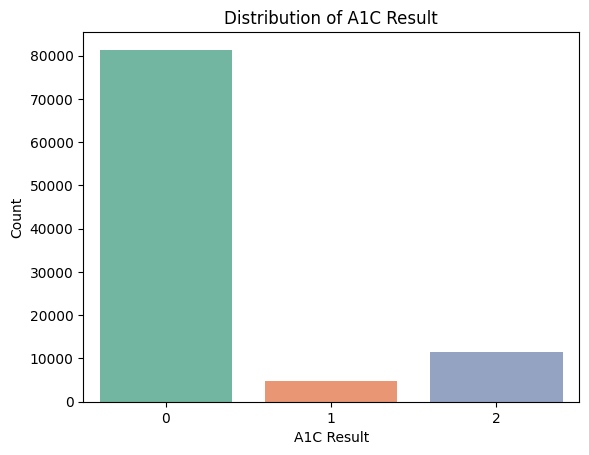

In [ ]:
#plot A1Cresult

a1c_data = df.select("A1Cresult").toPandas()

sns.countplot(x='A1Cresult', data=a1c_data, palette="Set2")
plt.xlabel("A1C Result")
plt.ylabel("Count")
plt.title("Distribution of A1C Result")
plt.show()

In [ ]:
#21 change: change of medications indicates if there was a change in daibetic medications(dosage/generic name)
df.groupBy("change").count().orderBy(F.desc("count")).show()

+------+-----+
|change|count|
+------+-----+
|    No|52346|
|    Ch|45459|
+------+-----+



In [ ]:
#encoding medication "change" column
df=df.withColumn("change", F.when(F.col("change") == "No", 0)
                .when(F.col("change") == "Ch", 1)
                .otherwise(None)
)
df.groupBy("change").count().orderBy(F.desc("count")).show()                 

+------+-----+
|change|count|
+------+-----+
|     0|52346|
|     1|45459|
+------+-----+



In [ ]:
#22. diabetesMed: indicates if the patient was prescribed diabetic medications (yes/no)
df.groupBy("diabetesMed").count().orderBy(F.desc("count")).show()

+-----------+-----+
|diabetesMed|count|
+-----------+-----+
|        Yes|75497|
|         No|22308|
+-----------+-----+



In [ ]:
#encoding diabetesMed; yes (1) and no (0)
df = df.withColumn("diabetesMed", F.when(F.col("diabetesMed") == "No", 0)
                   .when(F.col("diabetesMed") == "Yes", 1)
                   .otherwise(None)
)
df.groupBy("diabetesMed").count().orderBy(F.desc("count")).show()

+-----------+-----+
|diabetesMed|count|
+-----------+-----+
|          1|75497|
|          0|22308|
+-----------+-----+



In [ ]:
#ecoding gender
df = df.withColumn("gender", F.when(F.col("gender") == "Female", 0)
                   .when(F.col("gender") == "Male", 1)
                   .otherwise(None)
)

df.groupBy("gender").count().orderBy(F.desc("count")).show()

+------+-----+
|gender|count|
+------+-----+
|     0|52663|
|     1|45142|
+------+-----+



In [ ]:
df.columns
print(f"Index({df.columns})")

Index(['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'])


In [ ]:
#23: #23 generic names for medications'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'

drug = df.columns[19:42]
print(drug)


['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']


In [ ]:
# medications with list of unique values  (No, Steady, Up, Down)
for col_name in drug:
    unique_values = [row[0] for row in df.select(col_name).distinct().limit(100).collect()]
    print(f"{col_name}: {unique_values}")

metformin: ['Steady', 'Up', 'No', 'Down']
repaglinide: ['Steady', 'Up', 'No', 'Down']
nateglinide: ['Steady', 'No', 'Down', 'Up']
chlorpropamide: ['Steady', 'Up', 'No', 'Down']
glimepiride: ['Steady', 'Up', 'No', 'Down']
acetohexamide: ['Steady', 'No']
glipizide: ['Steady', 'Up', 'No', 'Down']
glyburide: ['Steady', 'Up', 'No', 'Down']
tolbutamide: ['Steady', 'No']
pioglitazone: ['Steady', 'Up', 'No', 'Down']
rosiglitazone: ['Steady', 'Up', 'No', 'Down']
acarbose: ['Steady', 'Up', 'No', 'Down']
miglitol: ['Steady', 'No', 'Up', 'Down']
troglitazone: ['Steady', 'No']
tolazamide: ['Steady', 'Up', 'No']
examide: ['No']
citoglipton: ['No']
insulin: ['Steady', 'Up', 'No', 'Down']
glyburide-metformin: ['Steady', 'Up', 'No', 'Down']
glipizide-metformin: ['No', 'Steady']
glimepiride-pioglitazone: ['No', 'Steady']
metformin-rosiglitazone: ['No', 'Steady']
metformin-pioglitazone: ['No', 'Steady']


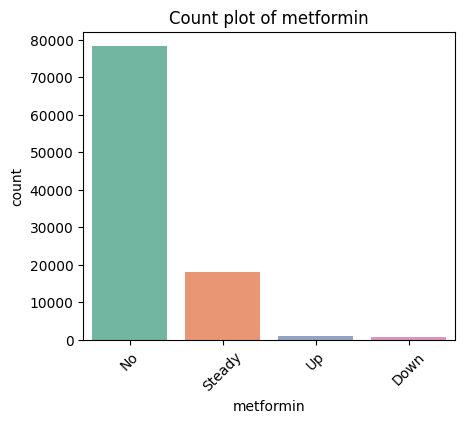

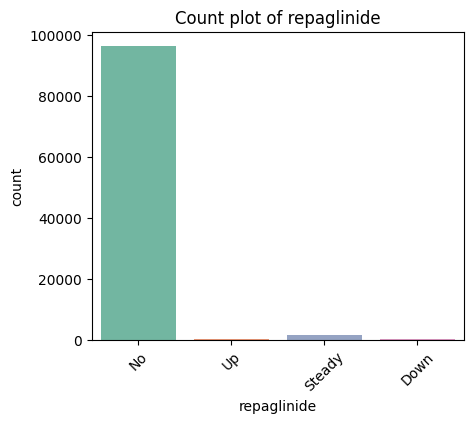

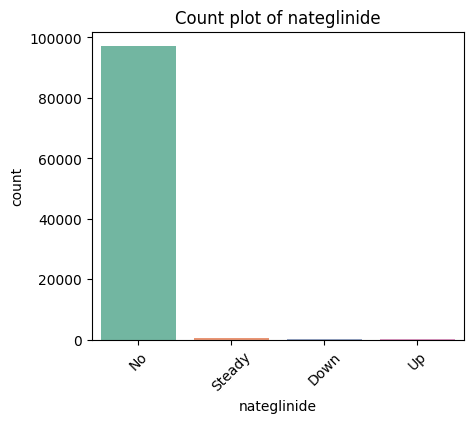

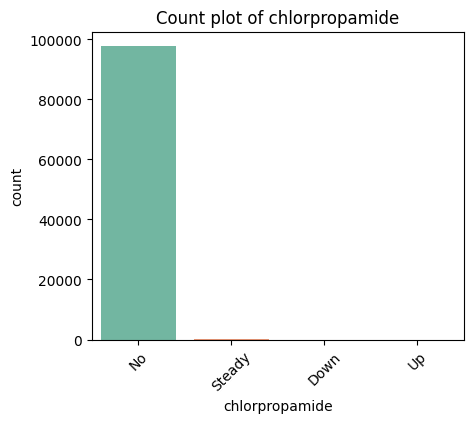

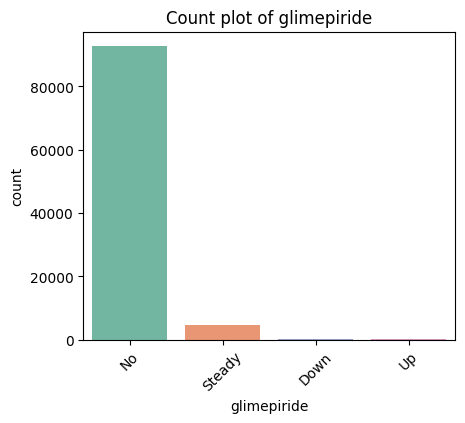

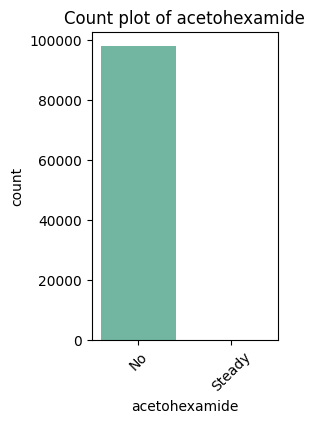

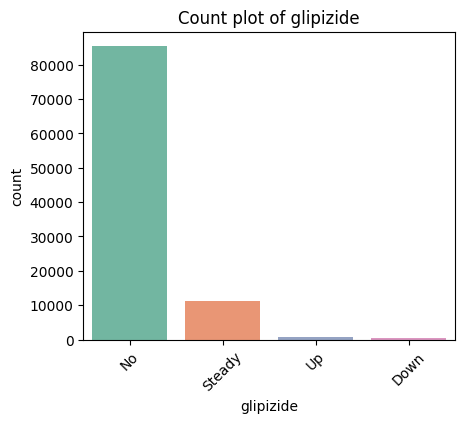

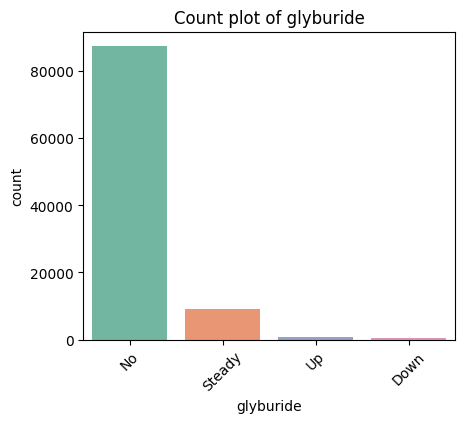

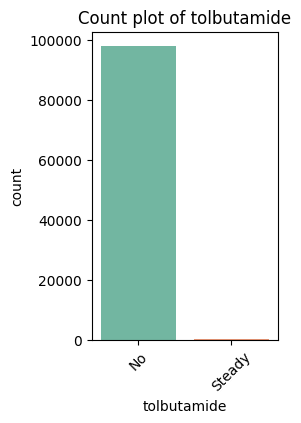

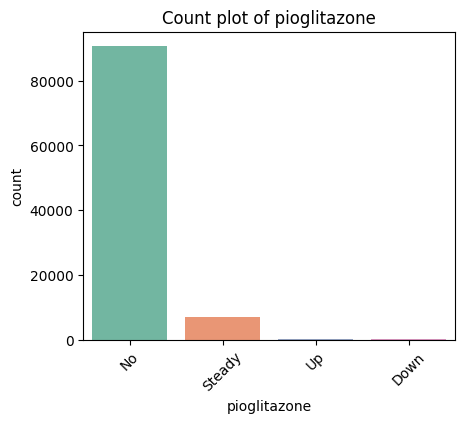

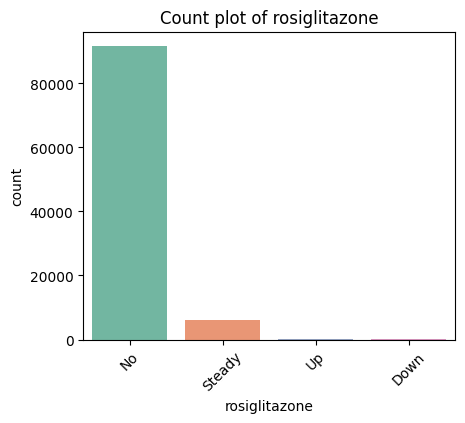

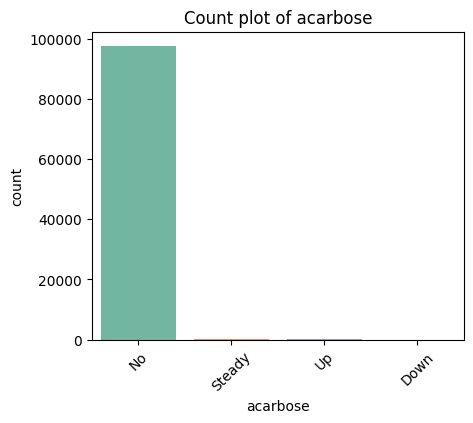

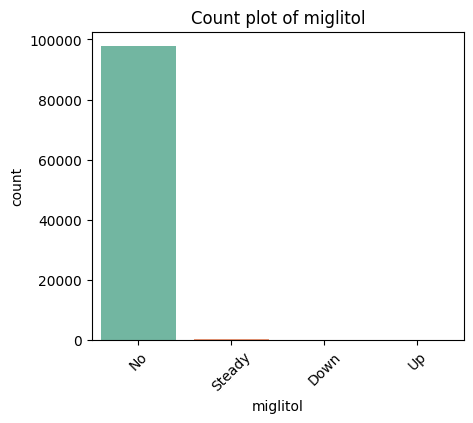

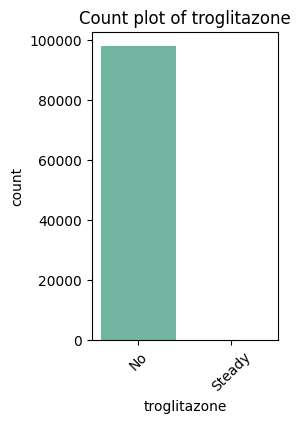

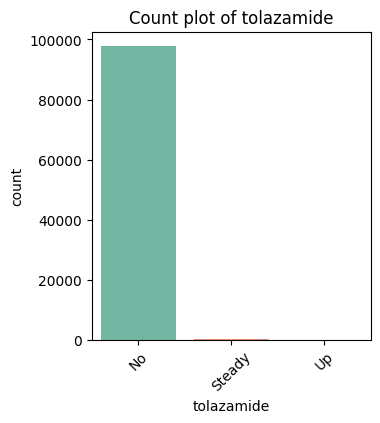

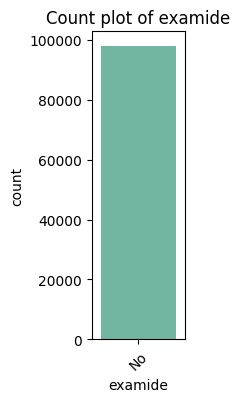

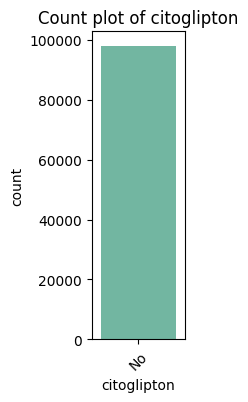

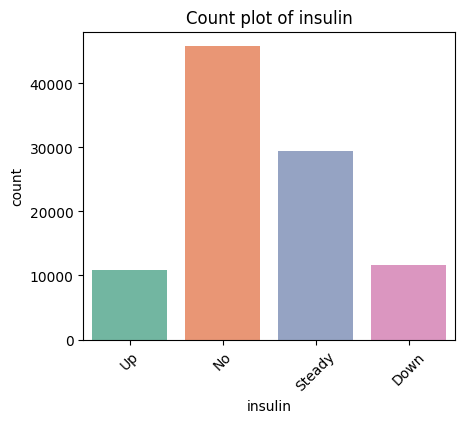

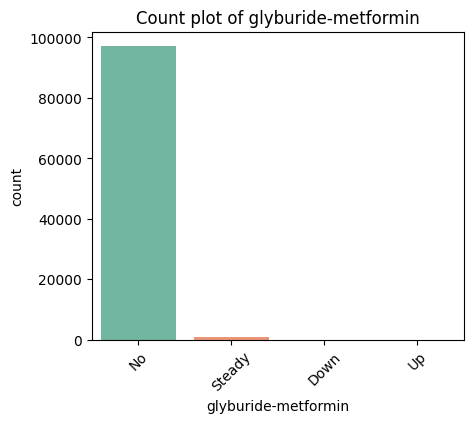

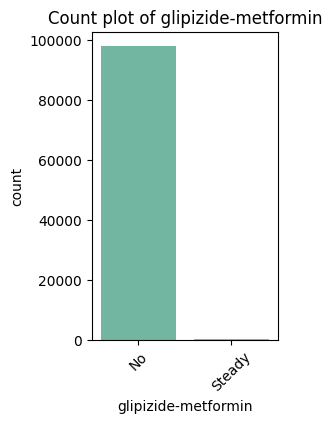

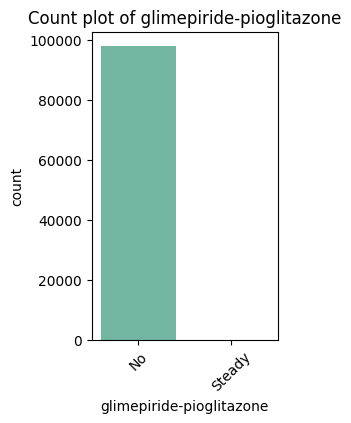

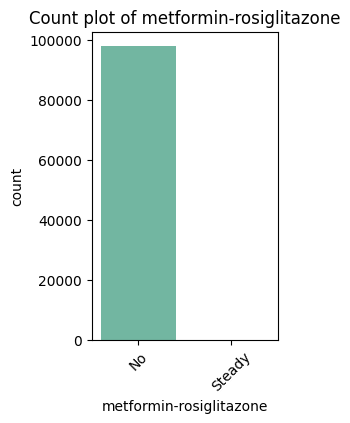

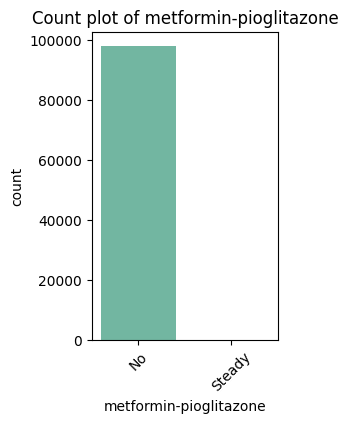

In [ ]:
#plot medications

palette_colors =sns.color_palette("Set2")

for col in drug:
    data = df.select(col).toPandas()
    plt.figure(figsize=(len(data[col].unique())*1.2,4))
    sns.countplot(x=col, data=data, palette=palette_colors)
    plt.title(f"Count plot of {col}")
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
#Two drugs (examide and citoglipton) have the similar values which couldn't provide
#interpretive infor/impact on target and confirm by counting the values
df.groupBy("citoglipton").count().orderBy(F.desc("count")).show()

+-----------+-----+
|citoglipton|count|
+-----------+-----+
|         No|97805|
+-----------+-----+



In [ ]:
df.groupBy("examide").count().orderBy(F.desc("count")).show()

+-------+-----+
|examide|count|
+-------+-----+
|     No|97805|
+-------+-----+



In [ ]:
df=df.drop("citoglipton", "examide")

In [ ]:
#select similar pattern possing medicines
l1=['metformin', 'glipizide', 'insulin', 'glyburide']

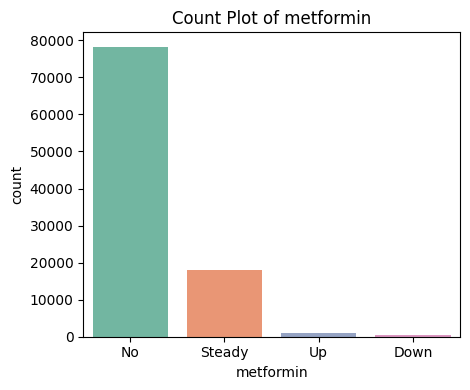

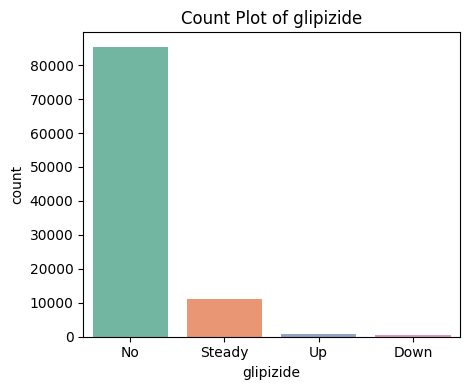

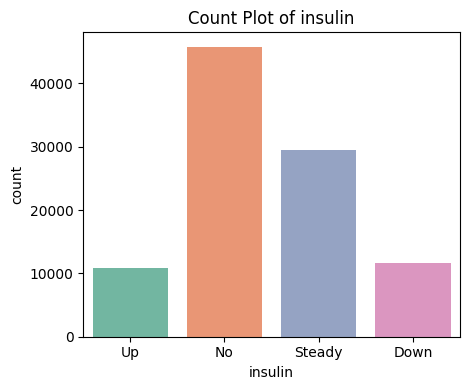

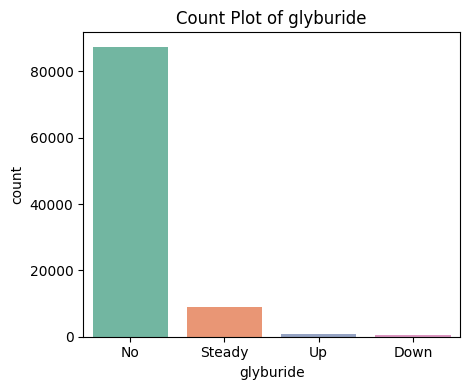

In [ ]:
for col in l1:
    data = df.select(col).toPandas()
    plt.figure(figsize=(len(data[col].unique()) * 1.2, 4))

    sns.countplot(x=col, data=data, palette=palette_colors)
    plt.title(f"Count Plot of {col}")
    plt.tight_layout()
    plt.show()


In [ ]:
for col in l1:
    print(col)
    counts = df.groupBy(col).count()

    total = df.count()
    df.groupBy(col).count() \
        .withColumn("percentage", F.round((F.col("count") / total * 100), 2)) \
        .orderBy(F.desc("percentage")) \
        .select(col, "percentage") \
        .show()

metformin
+---------+----------+
|metformin|percentage|
+---------+----------+
|       No|      80.0|
|   Steady|     18.36|
|       Up|      1.06|
|     Down|      0.58|
+---------+----------+

glipizide
+---------+----------+
|glipizide|percentage|
+---------+----------+
|       No|     87.32|
|   Steady|     11.35|
|       Up|      0.78|
|     Down|      0.56|
+---------+----------+

insulin
+-------+----------+
|insulin|percentage|
+-------+----------+
|     No|     46.82|
| Steady|     30.14|
|   Down|     11.97|
|     Up|     11.06|
+-------+----------+

glyburide
+---------+----------+
|glyburide|percentage|
+---------+----------+
|       No|     89.37|
|   Steady|      9.25|
|       Up|      0.82|
|     Down|      0.56|
+---------+----------+



In [ ]:
from pyspark.sql.functions import when

for col_name in l1:
    df = df.withColumn(col_name,when((F.col(col_name) == 'No') | 
                                     (F.col(col_name) == 'Steady'), 0).otherwise(1))

In [ ]:
df.groupBy("insulin").count().orderBy(F.desc("count")).show()

+-------+-----+
|insulin|count|
+-------+-----+
|      0|75274|
|      1|22531|
+-------+-----+



In [ ]:
df=df.drop('repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 
          'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 
           'miglitol', 'troglitazone', 'tolazamide','glyburide-metformin', 'glipizide-metformin', 
           'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone')

In [ ]:
# 26_ outcome variable "readmitted"
df.groupBy("readmitted").count().orderBy(F.desc("count")).show()

+----------+-----+
|readmitted|count|
+----------+-----+
|        NO|51475|
|       >30|35124|
|       <30|11206|
+----------+-----+



In [ ]:
# encoding readmitted column (multiclass to binary class)

df = df.withColumn(
    "readmitted",
    F.when(F.lower(F.col("readmitted")) == "no", 0)
     .when(F.col("readmitted") == ">30", 0)
     .when(F.col("readmitted") == "<30", 1)
     .otherwise(None)
)

In [ ]:
# 26_ outcome variable "readmitted"
df.groupBy("readmitted").count().orderBy(F.desc("count")).show()

+----------+-----+
|readmitted|count|
+----------+-----+
|         0|86599|
|         1|11206|
+----------+-----+



In [ ]:
df.show(5)

+---------------+------+---+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+---------+---------+-------+------+-----------+----------+
|           race|gender|age|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin|glipizide|glyburide|insulin|change|diabetesMed|readmitted|
+---------------+------+---+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+---------+---------+-------+------+-

In [ ]:
df.select("race").distinct().show()

+---------------+
|           race|
+---------------+
|      Caucasian|
|          Other|
|AfricanAmerican|
|       Hispanic|
|          Asian|
+---------------+



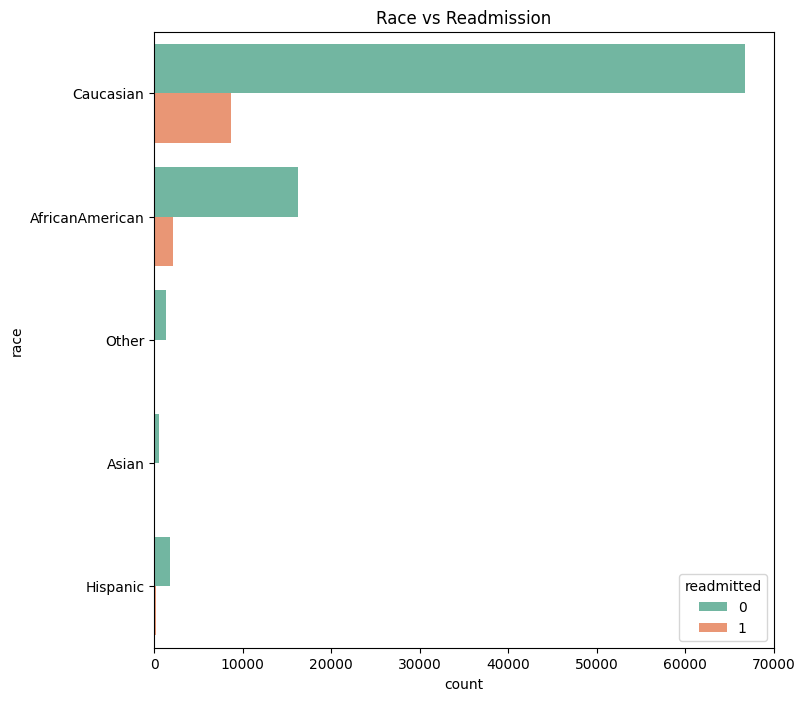

In [ ]:
plot_data= df.select("race", "readmitted").toPandas()
fig = plt.figure(figsize=(8,8))
sns.countplot(y='race', hue='readmitted', data=plot_data, palette='Set2')
plt.title("Race vs Readmission")
plt.show()

In [ ]:
#25_ Based on the figure the race has minimal impact on readmission, so we can drop it
df = df.drop("race")

In [ ]:
df.show(5)

+------+---+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+---------+---------+-------+------+-----------+----------+
|gender|age|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin|glipizide|glyburide|insulin|change|diabetesMed|readmitted|
+------+---+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+---------+---------+-------+------+-----------+----------+
|     0| 15|        Emerg

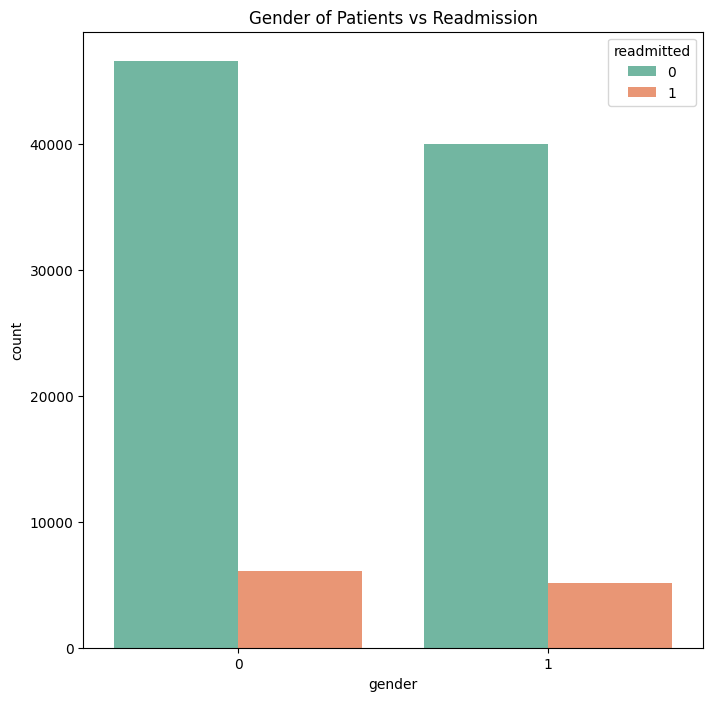

In [ ]:
#25 gender
plot_data = df.select("gender", "readmitted").toPandas()
fig = plt.figure(figsize=(8,8))
sns.countplot(x='gender', hue='readmitted', data=plot_data, palette='Set2')
plt.title("Gender of Patients vs Readmission")
plt.show()

In [ ]:
df.show(5)
print(len(df.columns))

+------+---+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+---------+---------+-------+------+-----------+----------+
|gender|age|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin|glipizide|glyburide|insulin|change|diabetesMed|readmitted|
+------+---+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+---------+---------+-------+------+-----------+----------+
|     0| 15|        Emerg

In [ ]:
'''
import os
os.environ["HADOOP_HOME"] = "C:\\hadoop"
os.environ["PATH"] += ";C:\\hadoop\\bin"
'''

'\nimport os\nos.environ["HADOOP_HOME"] = "C:\\hadoop"\nos.environ["PATH"] += ";C:\\hadoop\\bin"\n'

In [ ]:
# Save as CSV using pandas
df_pd = df.toPandas()
df_pd.to_csv("C:/Projects/hospital_readmission_prediction/data/output/cleaned_diabetic_data_1.csv", index=False)
